# Data Science - CA0

## 1. Data Collection (Etherscan)

In [123]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd

### 1.1 load driver

In [ ]:
driver = webdriver.Chrome()

In [ ]:
url = 'https://etherscan.io/txs'
driver.get(url)

The reason of choosing 20 blocks, is to try have full chain of a block(and it is because of etherscan paging is not completely in order of block)

In [ ]:
nBlocks = 20

We read all informations of the table, it takes more time so we spent more time in a page, and that slows down request, so we do not need to add any stop in extracting data.

### 1.2 extract datas

In [ ]:
blocks = set()
data = []
loop = True
while(loop):
    transaction_elements = driver.find_elements(By.CSS_SELECTOR, 'table.table tbody tr')
    for transaction_element in transaction_elements:
        hash = transaction_element.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').text
        method = transaction_element.find_element(By.CSS_SELECTOR, 'td:nth-child(3)').text
        block = transaction_element.find_element(By.CSS_SELECTOR, 'td:nth-child(4)').text
        age = transaction_element.find_element(By.CSS_SELECTOR, 'td:nth-child(6)').text
        from_ = transaction_element.find_element(By.CSS_SELECTOR, 'td:nth-child(8)').text
        to = transaction_element.find_element(By.CSS_SELECTOR, 'td:nth-child(10)').text
        value = transaction_element.find_element(By.CSS_SELECTOR, 'td:nth-child(11)').text
        fee = transaction_element.find_element(By.CSS_SELECTOR, 'td:nth-child(12)').text
        
        blocks.add(block)
        if(len(blocks) > nBlocks):
            loop = False
            break

        data.append([hash, method, block, age, from_, to, value, fee])
    
    next_page_button = driver.find_element(
        By.LINK_TEXT, 
        "Next"
    )
    
    next_page_button.click()

### 1.3 save the datas

then we save data in a dataframe so we can reuse it later.(saving is commented out to prevemnt loosing our saved data mistakenly!)

In [ ]:
df = pd.DataFrame(data, columns=[
    'Hash',
    'Method',
    'Block',
    'Age',
    'From',
    'To',
    'Value',
    'Fee' 
])

# df.to_csv(
#     'transaction_data.csv',
#     index=False, 
# )

In [ ]:
driver.quit()

## 2. Data Analysis

### 2.1 Load the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

data = pd.read_csv("./transaction_data.csv")

### 2.2 remove Duplicates

we can validate the transactions are unique according to the fact that `Hash` codes are unique. Also we need to drop `age` because a same data may be extracted in the different times and that may be not counted as duplicate.

In [3]:
data.drop(columns=['Age'], inplace=True)
print('original size:', data.shape[0])
data.drop_duplicates(ignore_index=True, inplace=True)
print('after removing duplicates:', data.shape[0])
print('number of unique hashes:', data['Hash'].nunique())

original size: 16200
after removing duplicates: 2947
number of unique hashes: 2947


THere is no need to hash anymore, so we drop it.

In [4]:
data.drop(columns=['Hash'], inplace=True)

### 2.3 Choose Blocks

we should choose `Blocks`, we do not choose first and last blocks. because we do not extract all that chain from the website(due to paging system).

In [5]:
data['Block'].value_counts()

19389841    243
19389840    243
19389845    200
19389842    189
19389850    179
19389851    177
19389847    170
19389835    167
19389834    165
19389836    157
19389849    151
19389844    143
19389837    141
19389843    137
19389846    129
19389848    124
19389839    121
19389833     50
19389838     45
19389852     16
Name: Block, dtype: int64

In [6]:
data = data[(data['Block'] >= 19389840) & (data['Block'] <= 19389849)]

In [7]:
data['Block'].value_counts()

19389840    243
19389841    243
19389845    200
19389842    189
19389847    170
19389849    151
19389844    143
19389843    137
19389846    129
19389848    124
Name: Block, dtype: int64

As you can see we have a better distribution for transactions in blocks

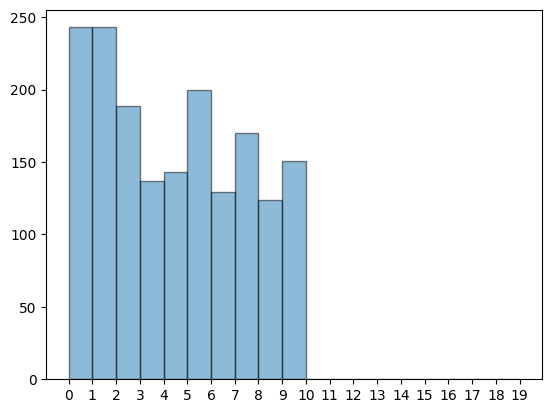

In [8]:
plt.hist(
    x = (data['Block'] - data['Block'].min()),
    bins = range(0, 20),
    alpha = 0.5,
    ec='black'
)
plt.xticks(range(0, 20))
plt.show()

### 2.4 Fix the data types 

the `Value` property has object type and we need to convert it to number. there are two unit type of etherium:

- ETH: etherium
- wei: The smallest unit of ETH is called a wei, which is equivalent to $10^{-18}$ ETH

In [9]:
def ethToFloat(x):
    if(x.endswith('ETH')):
        return float(x.replace(',', '').split()[0])
    elif(x.endswith('wei')):
        return float(x.replace(',', '').split()[0]) * 1e-18

data['Value'] = data['Value'].apply(ethToFloat)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 789 to 2584
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Method  1729 non-null   object 
 1   Block   1729 non-null   int64  
 2   From    1729 non-null   object 
 3   To      1729 non-null   object 
 4   Value   1729 non-null   float64
 5   Fee     1729 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 94.6+ KB


### 2.5 Statistical Analysis

In [11]:
import astropy.visualization as astplt
import scipy.stats as stats
import plotly.express as px
import pylab 

**z-score:**
$$ z = \frac{x - \mu}{\sigma} $$

- Approximately 68% of the data falls within one standard deviation of the mean (within a z-score range of -1 to 1).

- Approximately 95% of the data falls within two standard deviations of the mean (within a z-score range of -2 to 2).

- Approximately 99.7% of the data falls within three standard deviations of the mean (within a z-score range of -3 to 3).

In [12]:
def zScore(x, distRange):
    if(distRange == '65%'):
        r = 1
    elif(distRange == '95%'):
        r = 2
    elif(distRange == '99%'):
        r = 3
    else:
        raise ValueError
    return [x.mean() - r * x.std(), x.mean() + r * x.std()]

In [13]:
# def get_info(data, var, )
display(data.describe())
variables = ['Fee', 'Value']
for var in variables:
    mean = data[var].mean()
    std = data[var].std()
    median = data[var].median()
    print(
        var, ':' '\n'
        'mean:', mean, '\n'
        'std: ', std, '\n'
        'median', median, '\n'
        '[min, max]: ', f'[{data[var].min()}, {data[var].max()}]', '\n'
        '95%: ', f'[{zScore(data[var], "95%")[0]}, {zScore(data[var], "95%")[1]}]''\n'
    )

,Block,Value,Fee
count,1.729000e+03,1729.000000,1729.000000
mean,1.938984e+07,1.316346,0.004758
std,2.943625e+00,13.722905,0.007261
min,1.938984e+07,0.000000,0.000872
25%,1.938984e+07,0.000000,0.001117
50%,1.938984e+07,0.000010,0.002503
75%,1.938985e+07,0.100000,0.006883
max,1.938985e+07,400.057621,0.098077


Fee :
mean: 0.00475841979757085 
std:  0.00726101531237787 
median 0.00250314 
[min, max]:  [0.00087192, 0.09807661] 
95%:  [-0.009763610827184889, 0.01928045042232659]

Value :
mean: 1.3163461401769811 
std:  13.722904718422566 
median 1e-05 
[min, max]:  [0.0, 400.057621311] 
95%:  [-26.12946329666815, 28.762155577022114]



**Choosing bins:**

there are several methods to choose `bins`, we imported `astropy` to help us choosing them properly.

consider that:  $\text{Number of bins} = \frac{\text{Data range}}{\text{Bin width}}$


1. `Square Root Choice`:
 
$$\text{Number of bins} = \sqrt{N}$$

2. `Sturges' Formula`:

$$\text{Number of bins} = 1 + \log_2(N)$$

3. `Freedman-Diaconis Rule`:

$$\text{Bin width} = \frac{2 \times(Q_{3} - Q_{1})}{\sqrt[3]{N}}$$

- $Q1$ is the first quantile
- $Q3$ is the third qurntile

4. `Scott Formula`:

$$ \text{Bin Width} = \frac{3.5 \times \sigma}{\sqrt[3]{N}}$$

### 2.6 Fee Analysis

we can see `fee` has a better distribution to analyze, it ois because there are some rules which will be applied in transaction taxes.

#### 2.6.1 Boxplot and Violinplot

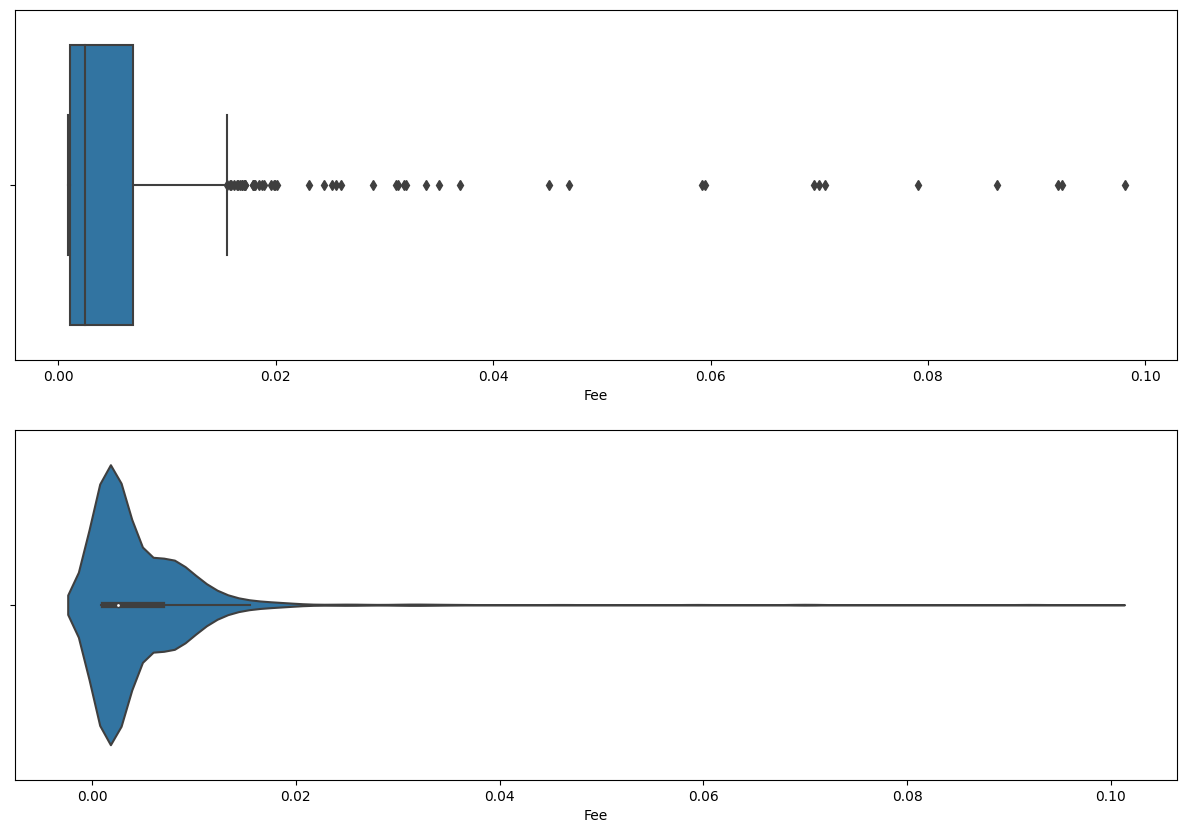

In [14]:
figure, axis = plt.subplots(2, 1, figsize=(15, 10))
sb.boxplot(
    x = data['Fee'],
    ax = axis[0]
)
sb.violinplot(
    x = data['Fee'],
    ax = axis[1]
)
plt.show()

#### 2.6.2 histogram

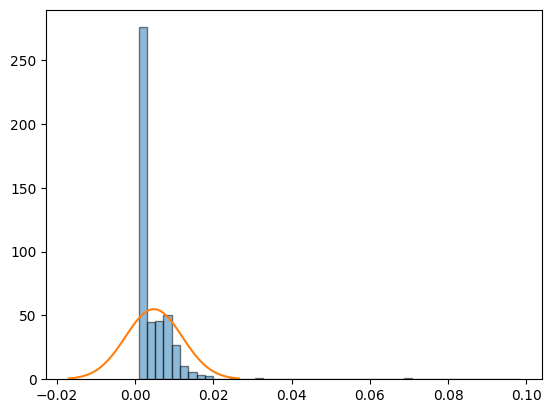

In [15]:
astplt.hist(
    data['Fee'],
    bins = 'scott',
    alpha = 0.5,
    ec='black',
    density = True
)

mu = data['Fee'].mean()
std = data['Fee'].std()
x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std))
plt.show()

#### 2.6.3 QQ Plot

The QQ plot is a helpful tool for visually assessing whether a dataset follows a normal distribution or not. If the points deviate from the straight line, it suggests that the dataset may not be normally distributed.

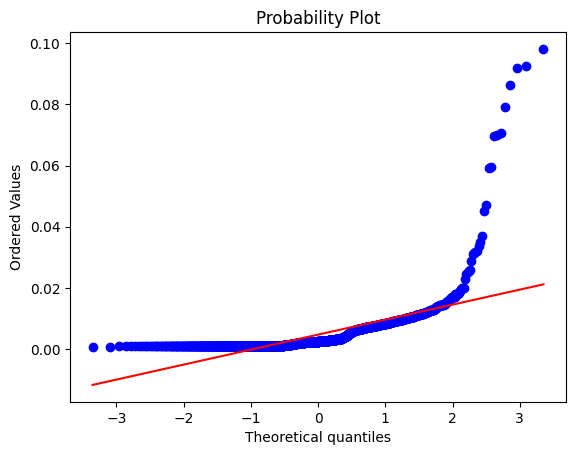

In [16]:
stats.probplot(data['Fee'], dist="norm", plot=pylab)
pylab.show()

### 2.7 Value

The `value` differs widely upon dataset and contains a wide range, later we will see effect of `method` in variation on `value`

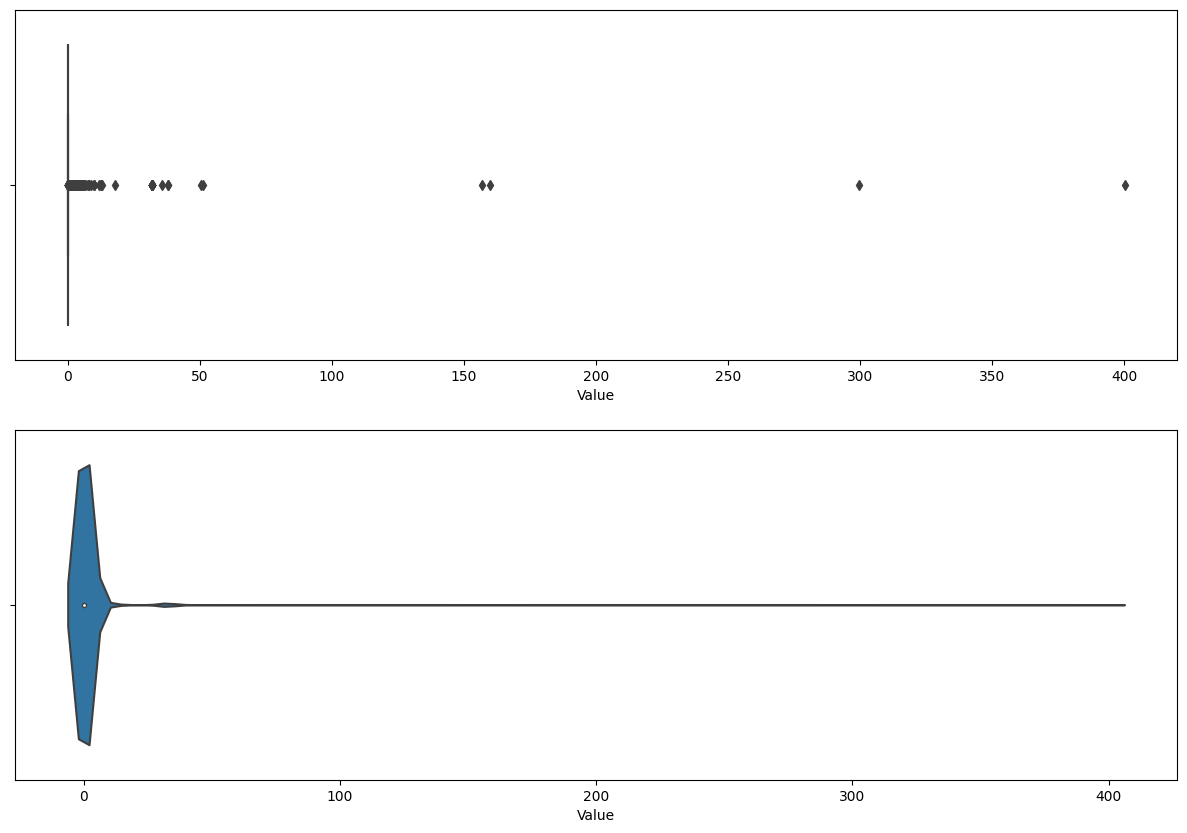

In [17]:
figure, axis = plt.subplots(2, 1, figsize=(15, 10))
sb.boxplot(
    x = data['Value'],
    ax = axis[0]
)
sb.violinplot(
    x = data['Value'],
    ax = axis[1]
)
plt.show()

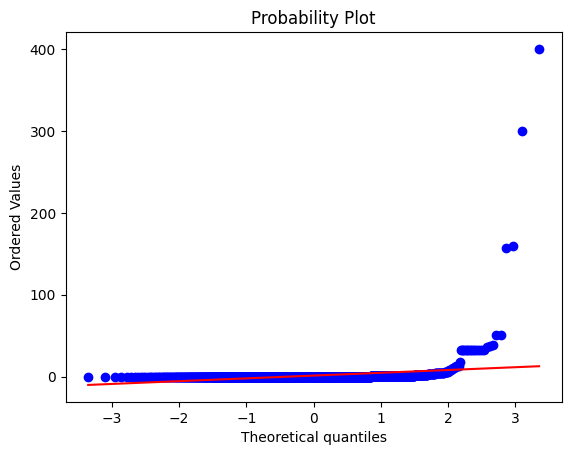

In [18]:
stats.probplot(data['Value'], dist="norm", plot=pylab)
pylab.show()

In [19]:
fig = px.box(
    x = data['Value']
)
fig.show()

due to the interactive plot(thanks to `plotly`) we can use a filterring to reduce variations and remove the outliers(not completely remove, just ignoring them in some analysis)

In [20]:
filtered = data[(data['Value'] >= 0) & (data['Value'] < 2.5)]['Value']

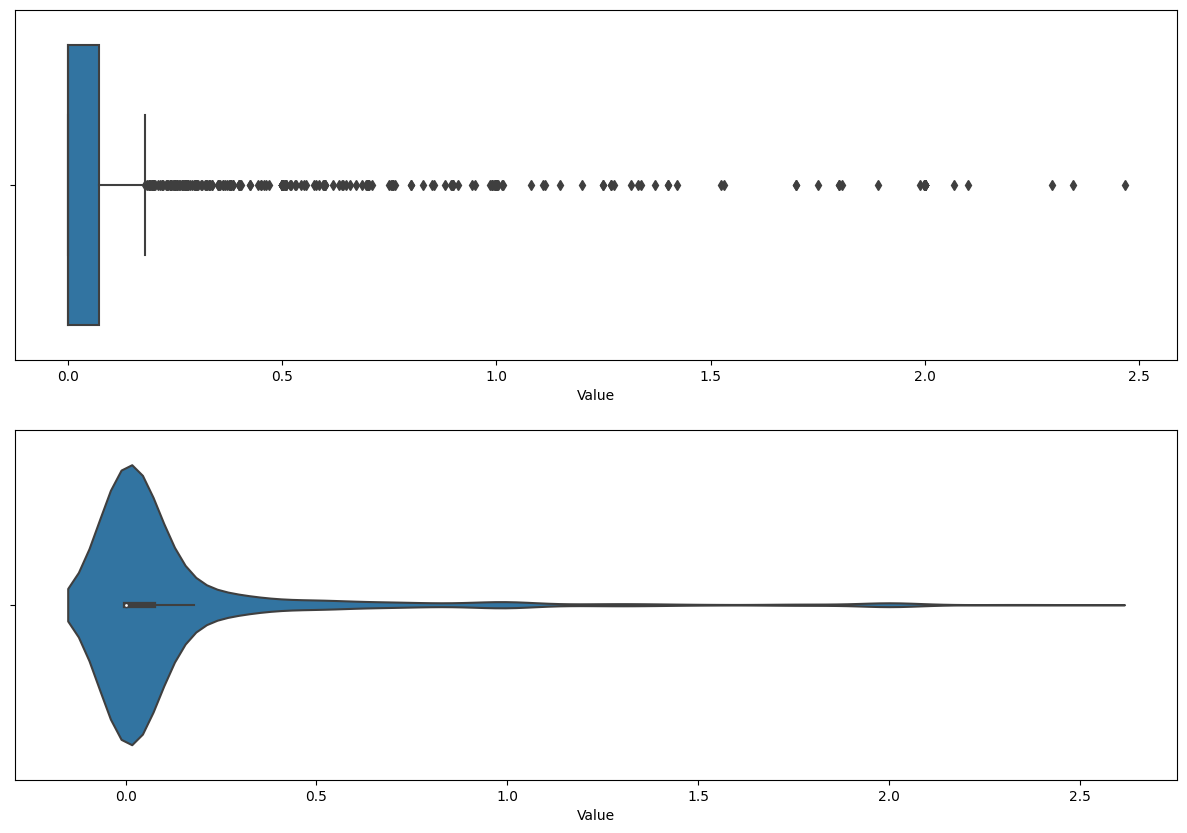

In [21]:
figure, axis = plt.subplots(2, 1, figsize=(15, 10))
sb.boxplot(
    x = filtered,
    ax = axis[0]
)
sb.violinplot(
    x = filtered,
    ax = axis[1]
)
plt.show()

filtered value:
mean: 0.12583032945167175 
std: 0.3335849951496422


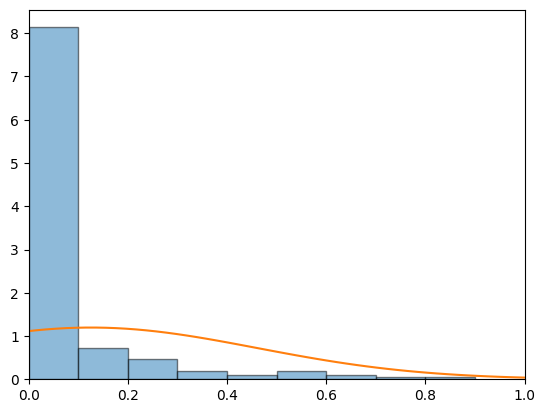

In [22]:
plt.hist(
    filtered,
    bins = np.arange(0, 1, 0.1),
    # bins = 'scott',
    alpha = 0.5,
    ec='black',
    density = True
)

mu = filtered.mean()
std = filtered.std()
print(f'filtered value:\n'
      'mean:', mu, '\n' 
      'std:', std)
x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std))
plt.xlim(0, 1)
plt.show()


### 2.8 Effect of Methods on Value 

In [23]:
methods = data['Method'].value_counts(sort=True).index.to_list()[0:5]
methods

['Transfer', 'Execute', 'Approve', 'Swap', 'Deposit']

- In a `Transfer` transaction, the value of the transaction would represent the amount of tokens or Ether being transferred from one address to another.

- In an `Execute` transaction, the value of the transaction may not be directly related to the value being executed, but rather to any gas fees or costs associated with executing the transaction.

- In an `Approve` transaction, the value of the transaction typically does not directly correlate with the approval itself but represents any gas fees or costs incurred during the approval process.

- In a `Swap` transaction, the value of the transaction would represent the value of the tokens being swapped or exchanged.

- In a `Deposit` transaction, the value of the transaction would typically represent the amount of tokens or Ether being deposited into a specific smart contract or DeFi protocol.

Transfer


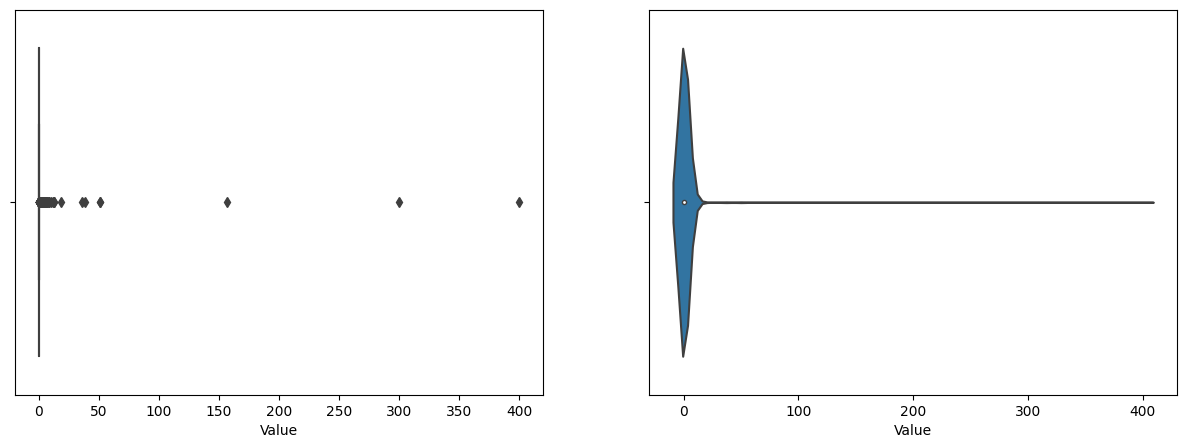

Execute


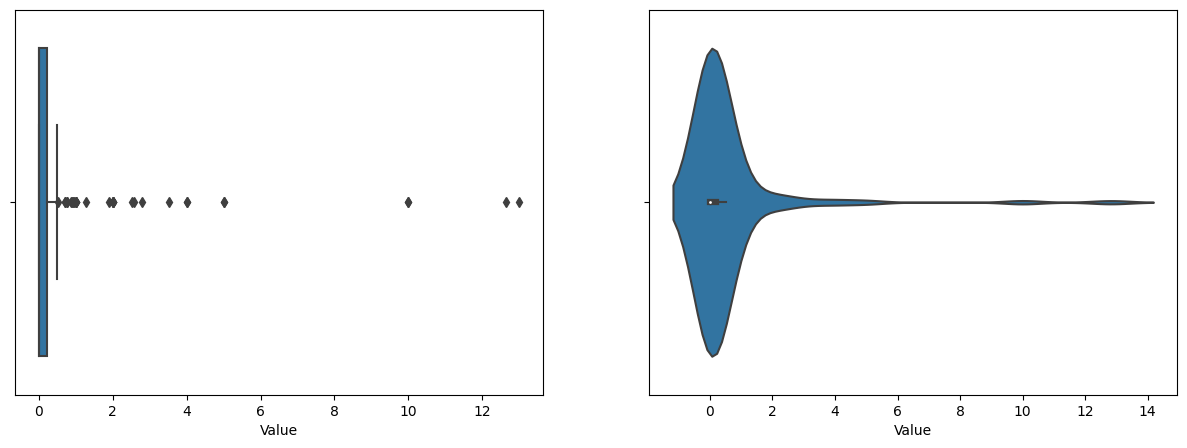

Approve


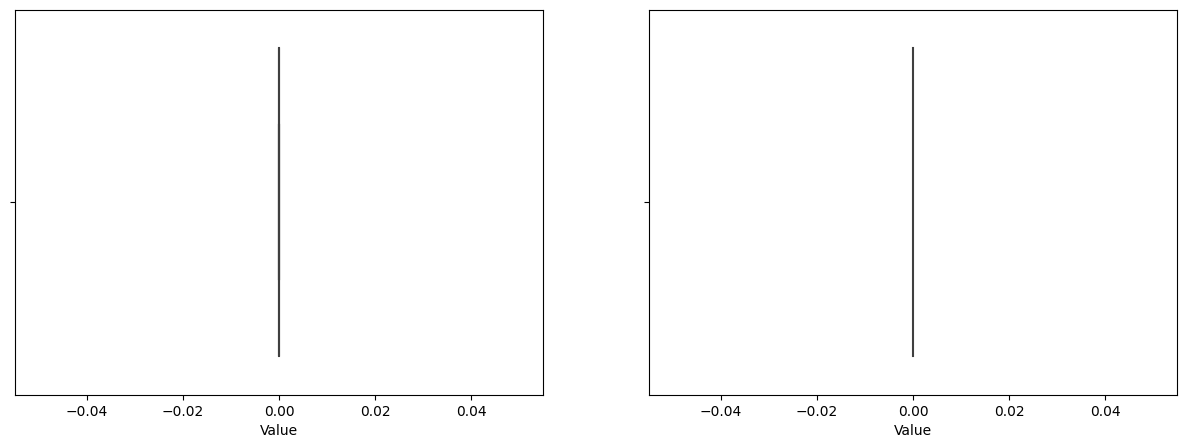

Swap


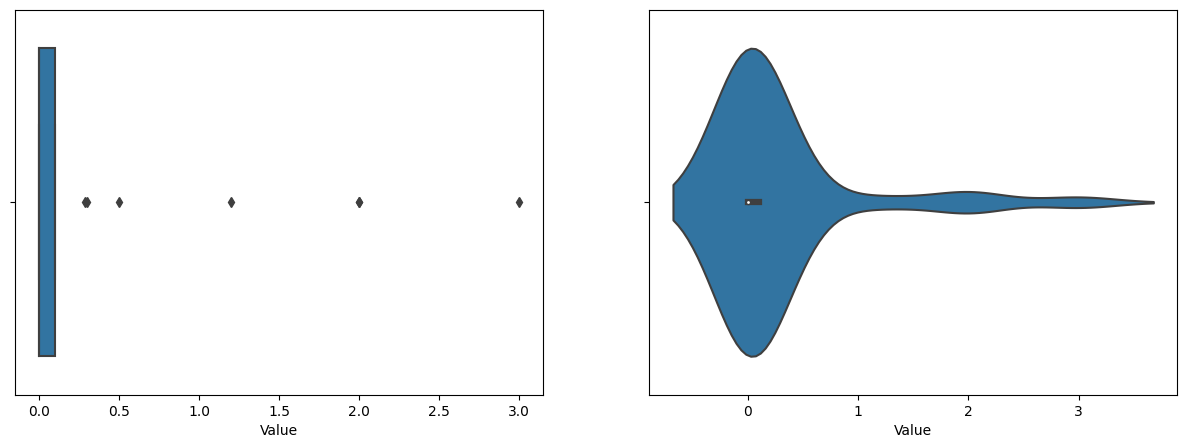

Deposit


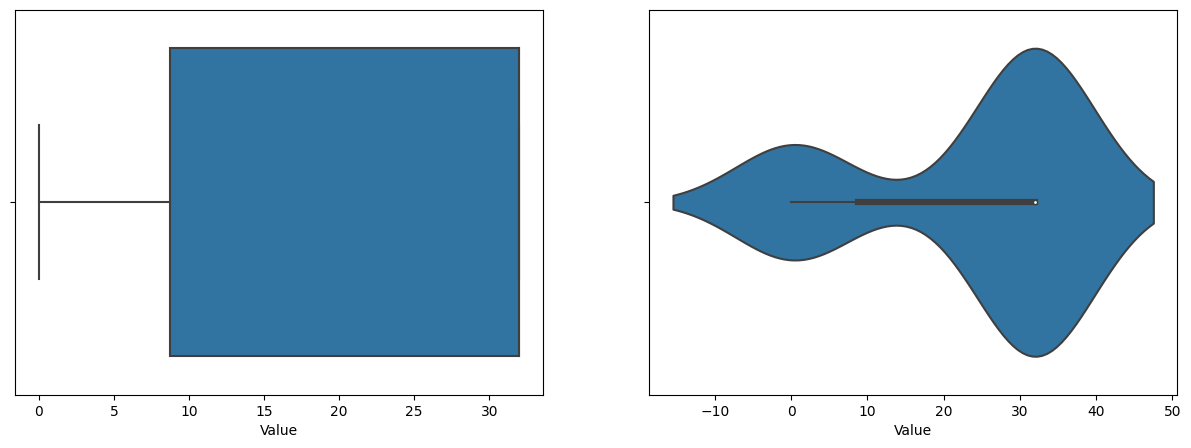

In [24]:
for method in methods:
    print(method)
    figure, axis = plt.subplots(1, 2, figsize=(15, 5))
    sb.boxplot(
        x = data[data['Method'] == method]['Value'],
        ax = axis[0]
    )
    sb.violinplot(
        x = data[data['Method'] == method]['Value'],
        ax = axis[1]
    )
    plt.show()

## 3. Data Sampling and Analysis

### 3.1 Simple Random Sampling


In [25]:
variable = ['Fee', 'Value']

In [26]:
def get_samples(x, percentage = 0.18):
    return x.sample(
        n = int(x.shape[0] * percentage)
    )

def report_stats(main: pd.Series, samples: pd.Series, name: str):
    astplt.hist(
        main,
        bins = 'scott',
        alpha = 0.5,
        ec='black',
        density = True,
        label = 'population'
    )
    astplt.hist(
        samples,
        bins = 'scott',
        alpha = 0.5,
        ec='black',
        density = True,
        label = 'samples'
    )
    plt.legend()
    plt.xlim(zScore(main, '99%'))
    plt.show()

    sb.violinplot(
        pd.DataFrame({'population': main, 'samples': samples}),
        split=True
    )
    plt.show()
    
    print(f'========== var: {name} ==========')
    print('mean:')
    print('all data: ', main.mean())
    print('samples: ', samples.mean())
    print('------------------------------')
    print('std:')
    print('all data: ', main.std())
    print('samples: ', samples.std())
    print('------------------------------')
    print('median:')
    print('all data: ', main.median())
    print('samples: ', samples.median())
    print()

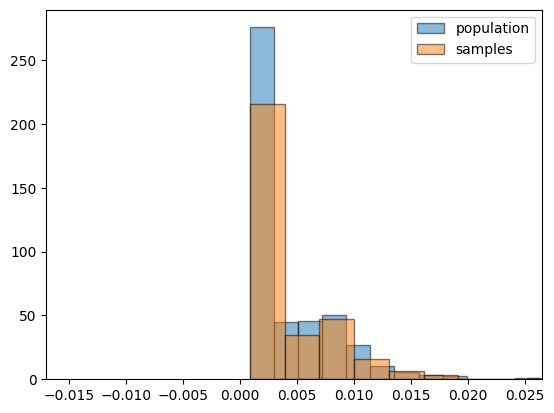

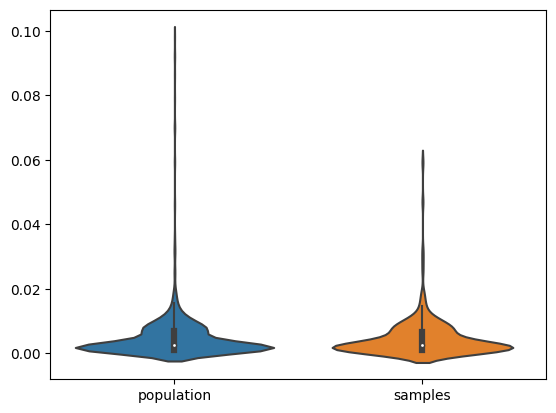

========== var: Fee ==========
mean:
all data:  0.00475841979757085
samples:  0.0045777253376205786
------------------------------
std:
all data:  0.00726101531237787
samples:  0.0059095064850708135
------------------------------
median:
all data:  0.00250314
samples:  0.00250314



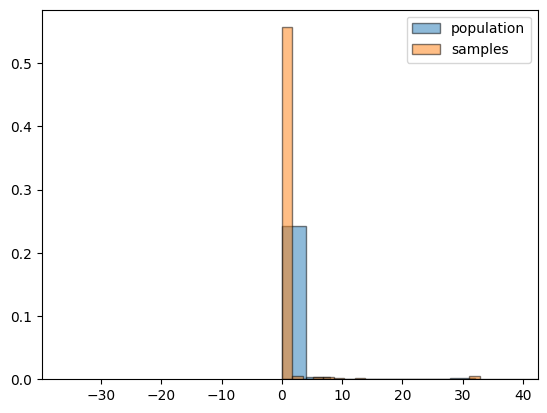

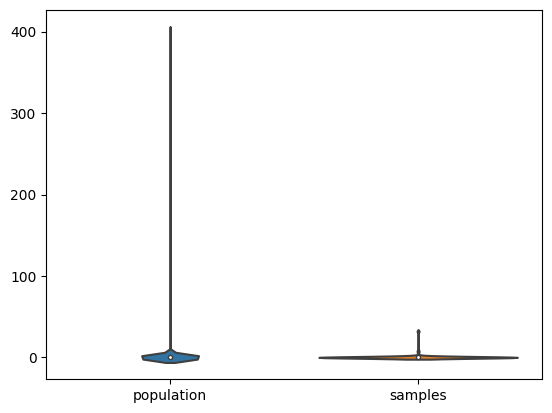

========== var: Value ==========
mean:
all data:  1.3163461401769811
samples:  0.5897143098681672
------------------------------
std:
all data:  13.722904718422566
samples:  3.3498589956665783
------------------------------
median:
all data:  1e-05
samples:  0.0



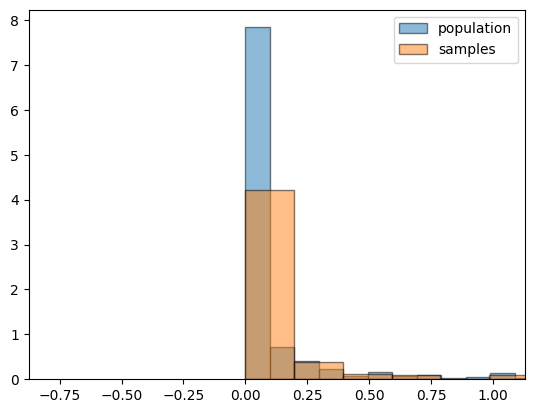

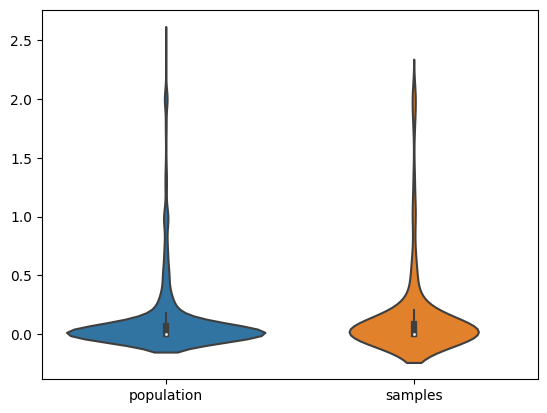

========== var: Filtered Value ==========
mean:
all data:  0.12583032945167175
samples:  0.14718093836824325
------------------------------
std:
all data:  0.3335849951496422
samples:  0.37494100308846445
------------------------------
median:
all data:  0.0
samples:  0.0014886765000000001



In [27]:
for var in variables:
    samples = get_samples(data[var])
    report_stats(data[var], samples, var)
    
samples = get_samples(filtered)
report_stats(filtered, samples, 'Filtered Value')

### 3.2 Statified: Blocks

now we can divide data into each block, and take sample from each block

Fee


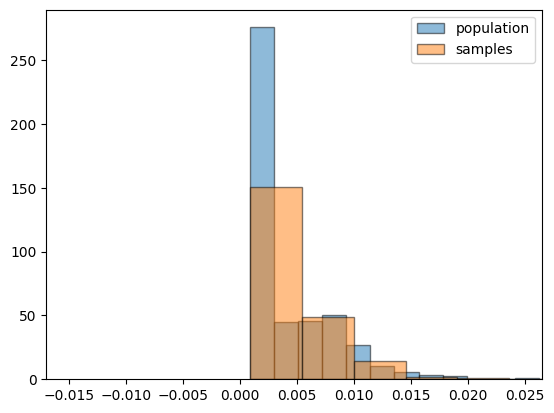

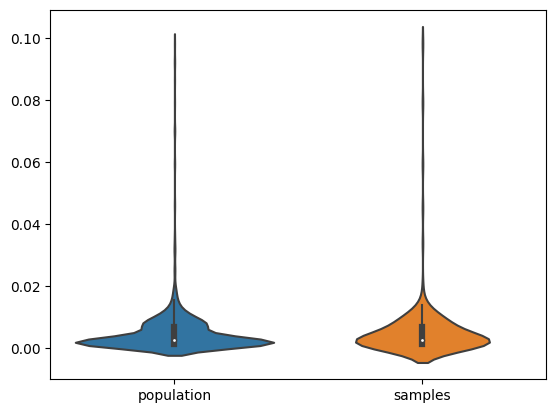

========== var: Fee - block ==========
mean:
all data:  0.00475841979757085
samples:  0.004991990130293159
------------------------------
std:
all data:  0.00726101531237787
samples:  0.00879652711095435
------------------------------
median:
all data:  0.00250314
samples:  0.00255594

Value


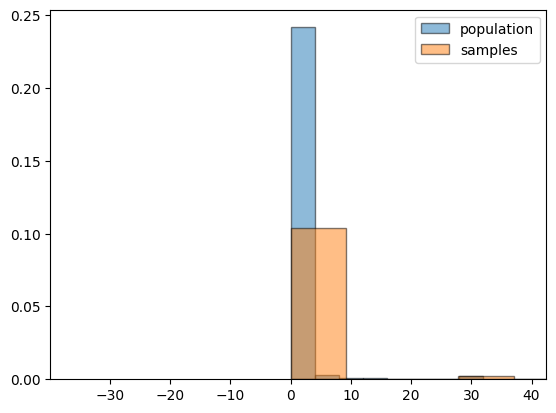

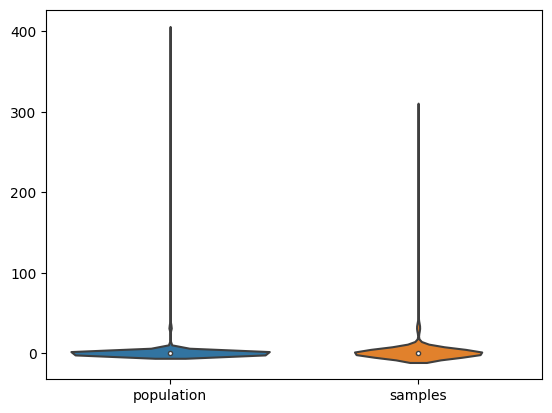

========== var: Value - block ==========
mean:
all data:  1.3163461401769811
samples:  2.192992766026059
------------------------------
std:
all data:  13.722904718422566
samples:  17.931909465578794
------------------------------
median:
all data:  1e-05
samples:  0.001947764



In [28]:
for var in variable:
    samples = pd.Series(dtype=float)
    print(var)
    for block in set(data['Block'].unique()):
        s = data[data['Block'] == block]
        samples = pd.concat([samples, get_samples(s[var])])
    report_stats(data[var], samples, f'{var} - block')
        

### 3.3 Statified: Methods

As we mentioned, each method has its own characteristics

Fee


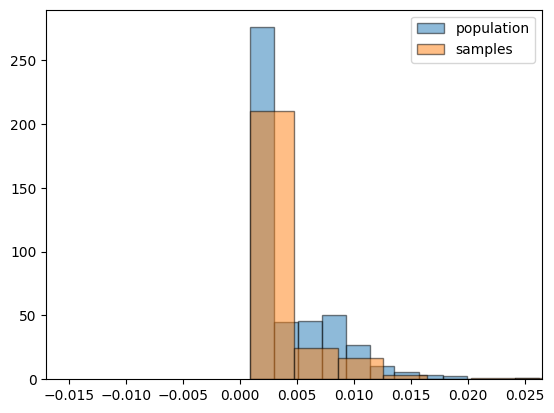

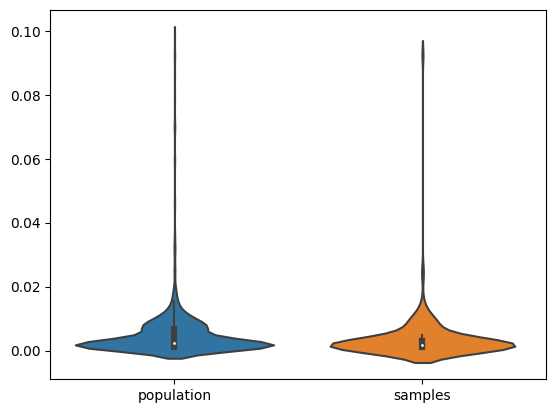

========== var: Fee - Method ==========
mean:
all data:  0.00475841979757085
samples:  0.0034872635622317594
------------------------------
std:
all data:  0.00726101531237787
samples:  0.006839366637021027
------------------------------
median:
all data:  0.00250314
samples:  0.00184301

Value


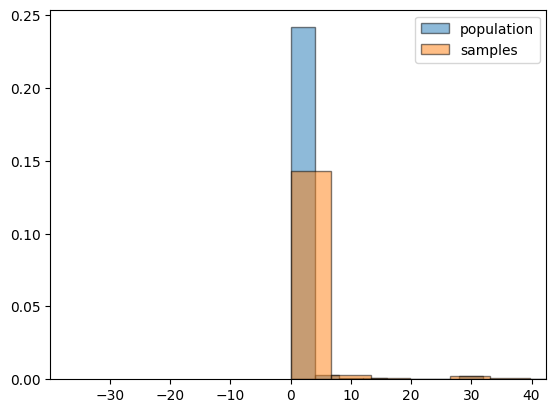

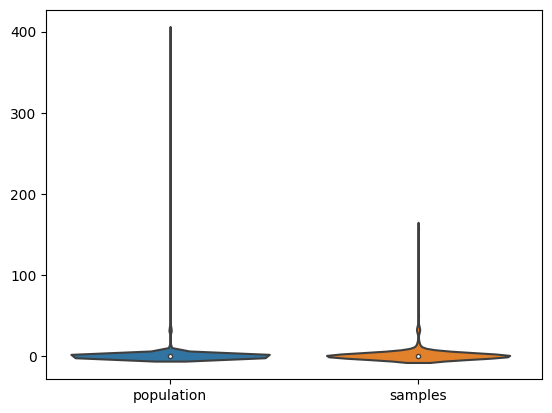

========== var: Value - Method ==========
mean:
all data:  1.3163461401769811
samples:  1.992562234914163
------------------------------
std:
all data:  13.722904718422566
samples:  11.693625308449404
------------------------------
median:
all data:  1e-05
samples:  0.003148934



In [29]:
for var in variable:
    print(var)
    samples = pd.Series(dtype=float)
    for method in methods:
        s = data[data['Method'] == method]
        samples = pd.concat([samples, get_samples(s[var])])
    report_stats(data[var], samples, f'{var} - Method')

### 3.4 Statified: Fee

we divide data based on `Fee` quantiles 

In [30]:
quantileRange = lambda i, n: (i / n, (i + 1) / n)

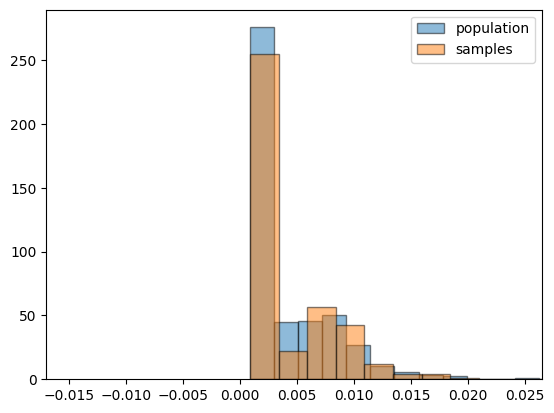

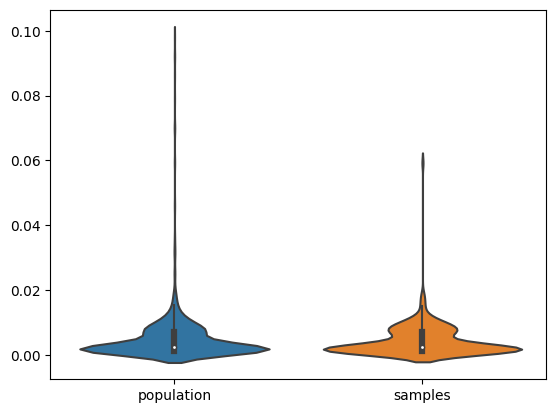

========== var: Fee - fee quntile ==========
mean:
all data:  0.00475841979757085
samples:  0.004293429350649351
------------------------------
std:
all data:  0.00726101531237787
samples:  0.004852662787588597
------------------------------
median:
all data:  0.00250314
samples:  0.0025053



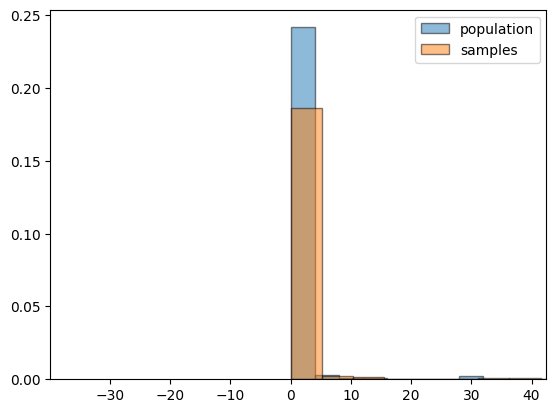

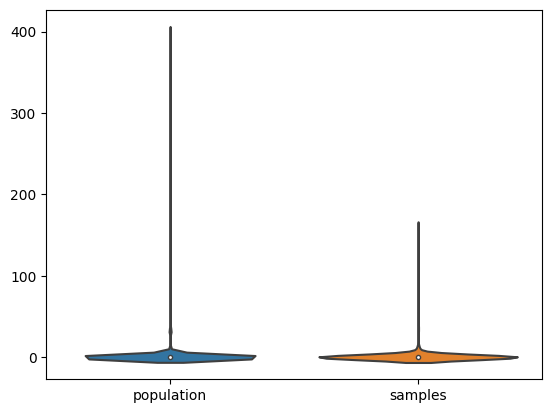

========== var: Value - fee quntile ==========
mean:
all data:  1.3163461401769811
samples:  1.3110186320454544
------------------------------
std:
all data:  13.722904718422566
samples:  10.027948584979802
------------------------------
median:
all data:  1e-05
samples:  1.45e-08



In [31]:
nQuntiles = 6
for var in variables:
    samples = pd.Series(dtype = float)
    for i in range(nQuntiles):
        l = data['Fee'].quantile(quantileRange(i, nQuntiles)[0])
        r = data['Fee'].quantile(quantileRange(i, nQuntiles)[1])
        s = data[(data['Fee'] >= l) & (data['Fee'] < r)][var]
        samples = pd.concat([samples, get_samples(s)])
    report_stats(data[var], samples, f'{var} - fee quntile')

# 4. Questions

**1. What are some potential limitations when using web scraping for data collection? Specifically, what problems did you face while fetching data from Etherscan? What problems can these limitations cause in your analysis?**

- `Legal and ethical issues`: Web scraping may violate the terms of service of some websites and could potentially be illegal.

- `Website changes`: Websites frequently update their structure and content, which can break the web scraping process.

- `Rate limits and access restrictions`: Many websites have rate limits or may block access to users who are scraping their data.

**2. What can make your analysis untrustworthy? What are your solutions?**

- `Biased data selection`: If the data used for analysis is not representative of the entire population or is selectively chosen to support a particular hypothesis, the analysis can be biased. This can lead to misleading conclusions.

- `Data quality issues`: Inaccurate, incomplete, or outdated data can significantly impact the reliability of the analysis.

To address these potential issues and ensure the trustworthiness of an analysis, we can:

- `Use high-quality data`: Ensure that the data used for analysis is comprehensive and accurate. Address any data quality issues through data cleaning and validation processes.

- `Use proper methods`: Clearly define the methodology used for data collection, analysis, and modeling.

- `Validate results`: Use validation techniques such as visualization.


**3. How did the visualization help you in understanding the data? What could you interpret from the plots?**

- `Identifying patterns`: Visualizations make it easier to spot patterns in the data.

- `Comparing data`: Visualizations allow for quick and easy comparison of different data sets, helping to identify differences and similarities between variables and methods.

- `Detecting outliers`: Visual representations of data can make it easier to identify outliers that may not be as apparent in tabular data.

- `Understanding relationships`: Visualizations can show the relationships between different variables, such as correlation or causation, making it easier to understand how changes in one variable affect another.

**4. How do the two sampling methods differ in their output? Compare these and explain which one is a better fit to the population.**

- `Simple Random Sampling`: The output of simple random sampling provides estimates and inferences about the entire population, without specific emphasis on characteristics of individual subgroups. It may not provide detailed insights.

- `Stratified Sampling`: The output of stratified sampling allows for more precise estimates for each subgroup. This enables separate analysis within each group.

As we saw startified sampling results better.